# Whatever

For reference, dimensions of the data:
```python
    # Create a vector of node features including index, type, Vm, Va, Pd, Qd, Gs, Bs
    case['bus'] = x[0]['bus']
    node_features_y = np.zeros((case['bus'].shape[0], 8))
    node_features_y[:, 0] = case['bus'][:, 0]  # index
    node_features_y[:, 1] = case['bus'][:, 1]  # type
    # Vm ----This changes for Load Buses
    node_features_y[:, 2] = case['bus'][:, 7]
    # Va ----This changes for every bus excecpt slack bus
    node_features_y[:, 3] = case['bus'][:, 8]
    node_features_y[:, 4] = case['bus'][:, 2]  # Pd
    node_features_y[:, 5] = case['bus'][:, 3]  # Qd
    node_features_y[:, 6] = case['bus'][:, 4]  # Gs
    node_features_y[:, 7] = case['bus'][:, 5]  # Bs
```

## Load Modules

In [186]:
import os

import torch
import torch_geometric
import matplotlib.pyplot as plt

from datasets.PowerFlowData import PowerFlowData
from networks.MPN import MPN
from utils.evaluation import load_model

LOG_DIR = 'logs'
SAVE_DIR = 'models'

os.makedirs(LOG_DIR+'/results', exist_ok=True)


In [187]:
feature_names = [
    'index',                # -
    'type',                 # -
    'voltage magnitude',    # --- we care about this
    'voltage angle',        # --- we care about this
    'active power',         # --- we care about this
    'reactive power',       # --- we care about this
    'Gs',                   # -
    'Bs'                    # -
]

feature_names_output = [
    'voltage magnitude',    # --- we care about this
    'voltage angle',        # --- we care about this
    'active power',         # --- we care about this
    'reactive power',       # --- we care about this
    'Gs',                   # -
    'Bs'                    # -
]

## Visualize results
Load saved model and prepare data. Select only 100 samples for simplicity.

In [194]:
#case118
run_id = '20230614-9695'
num_samples = 10000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
testset = PowerFlowData(root='data', case='118', split=[.5, .2, .3], task='test')
print('testset', len(testset))
mean = testset.xymean[0]
std = testset.xystd[0]

testloader = torch_geometric.loader.DataLoader(testset, batch_size=1, shuffle=False)



node_in_dim, node_out_dim, edge_dim = testset.get_data_dimensions()
model = MPN(
    nfeature_dim=node_in_dim, 
    efeature_dim=edge_dim, 
    output_dim=node_out_dim, 
    hidden_dim=64, #16 765
    n_gnn_layers=2, 
    K=3, 
    dropout_rate=0.2
).to(device) # 40k params

#case14
# run_id = '20230614-949'
# num_samples = 10000

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# testset = PowerFlowData(root='data', case='118', split=[.5, .2, .3], task='test')
# print('testset', len(testset))
# mean = testset.xymean[0]
# std = testset.xystd[0]

# testloader = torch_geometric.loader.DataLoader(testset, batch_size=1, shuffle=False)

# node_in_dim, node_out_dim, edge_dim = testset.get_data_dimensions()
# model = MPN(
#     nfeature_dim=node_in_dim, 
#     efeature_dim=edge_dim, 
#     output_dim=node_out_dim, 
#     hidden_dim=32, #16 765
#     n_gnn_layers=2, 
#     K=3, 
#     dropout_rate=0.2
# ).to(device) # 40k params

model, _ = load_model(model, run_id, device)

preds = []
targets = []
import time
start = time.time()
with torch.no_grad():
    for i, sample in enumerate(testloader):
        if i == num_samples:
            break
        sample = sample.to(device)
        pred = model(sample)
        preds.append(pred)
        targets.append(sample.y)

end = time.time()
print('time', (end-start)/num_samples)
preds = torch.stack(preds, dim=0).cpu()*std + mean
targets = torch.stack(targets, dim=0).cpu()*std + mean
error = preds - targets
print('preds', preds.shape)

testset 50000
time 0.004722706198692321
preds torch.Size([10000, 118, 6])


In [177]:
print(mean,std)

tensor([ 0.9851, -1.0368,  4.7025, 18.4991,  0.0000,  1.3571]) tensor([3.4745e-02, 2.7941e+00, 4.5458e+01, 2.7670e+01, 0.0000e+00, 4.8932e+00])


### Error for all scenarios for one node

In [179]:
node_ID = 7
error_node = error[:, node_ID, :]
scenarios = torch.arange(len(error_node))
target_node = targets[:, node_ID, :]
pred_node = preds[:, node_ID, :]

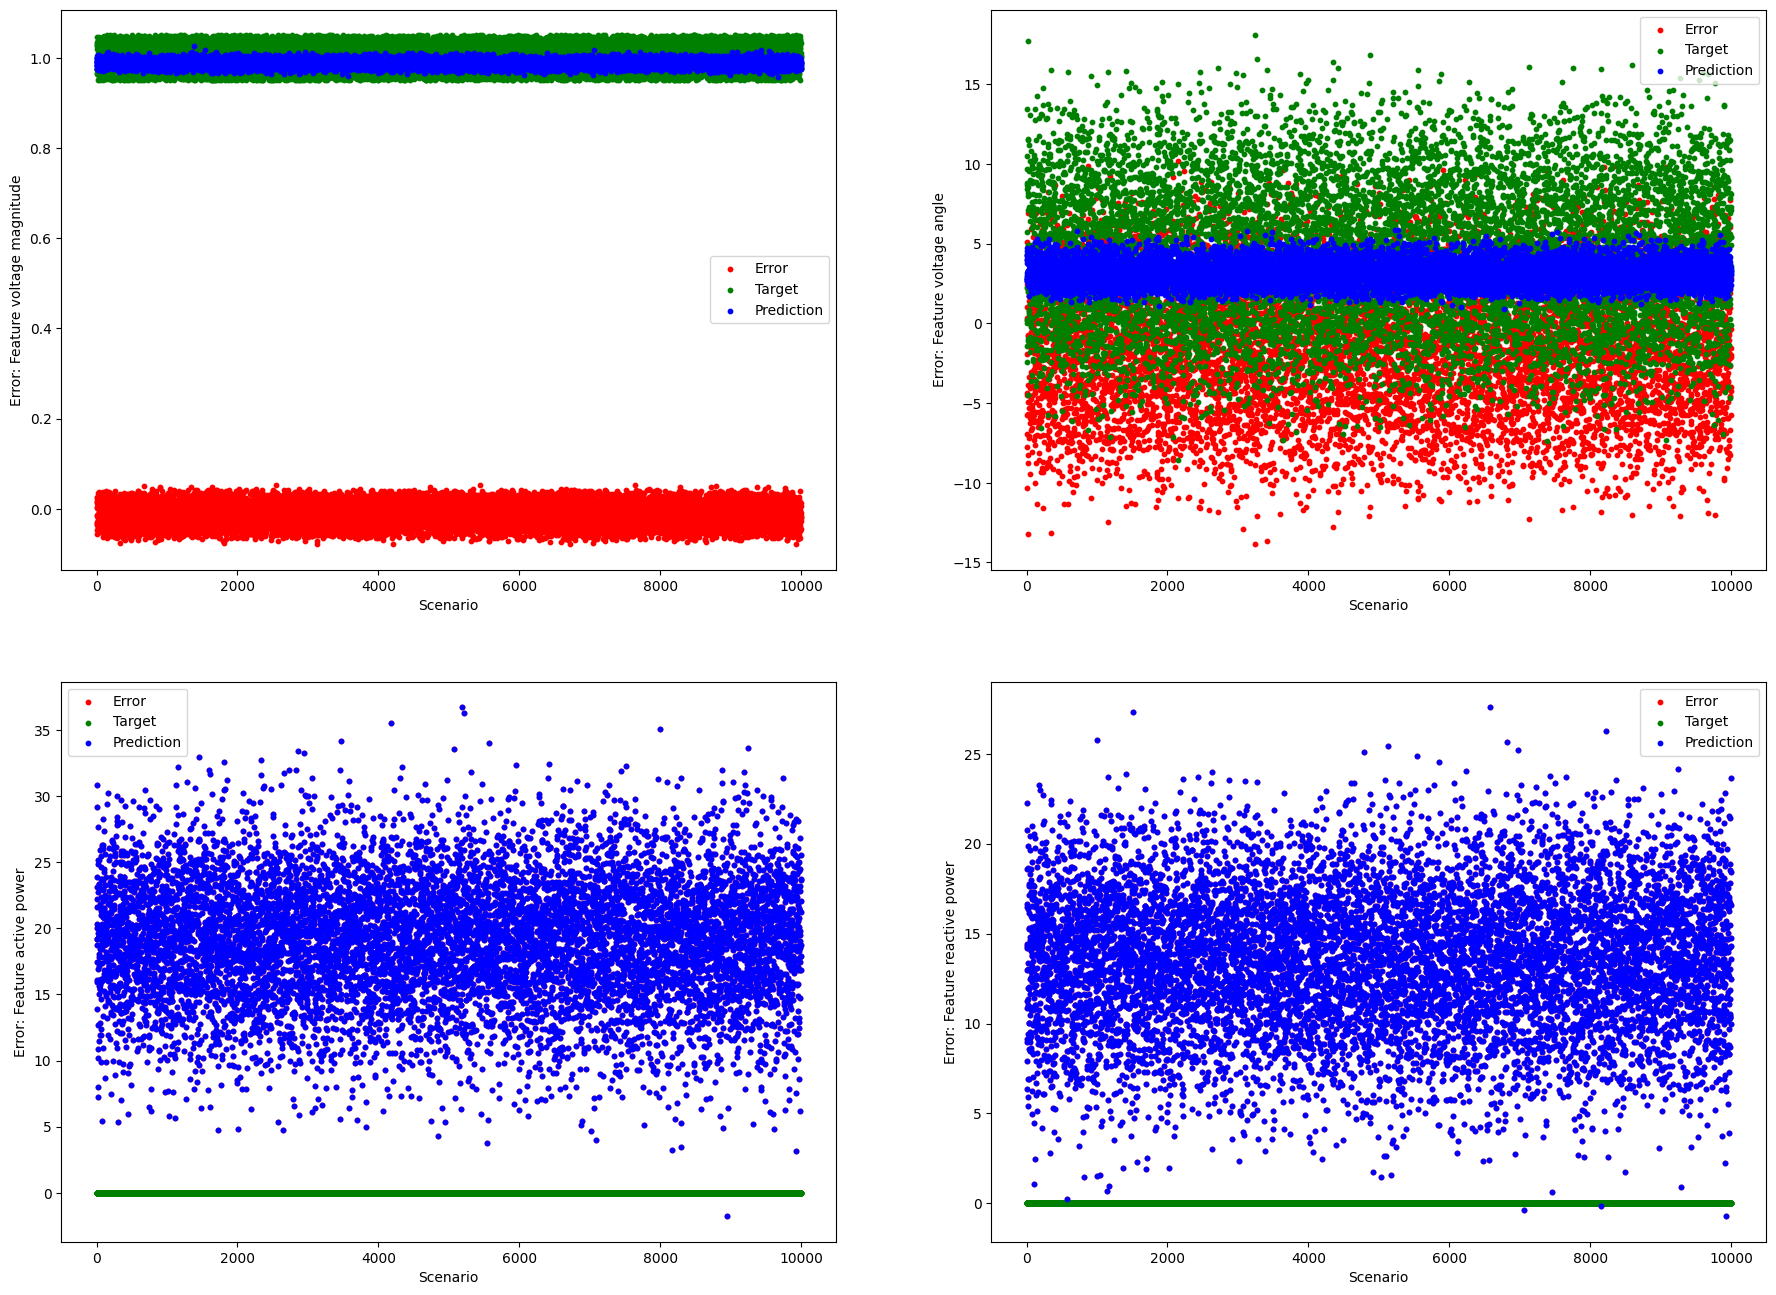

In [180]:
indices = torch.arange(len(error_node))

fig, axes = plt.subplots(2, 2, figsize=(22, 16))
for idx, ax in enumerate(axes.flatten()):
    ax.scatter(scenarios, error_node[indices, idx], c='red', label='Error', s=10)
    ax.scatter(scenarios, target_node[indices, idx], c='green', label='Target', s=10)
    ax.scatter(scenarios, pred_node[indices, idx], c='blue', label='Prediction', s=10)
    ax.set_xlabel('Scenario')
    ax.set_ylabel(f'Error: Feature {feature_names_output[idx]}')
    ax.legend()
    
plt.savefig(LOG_DIR+'/results/'+'error_all_scenarios_'+run_id+'.png')
plt.show()

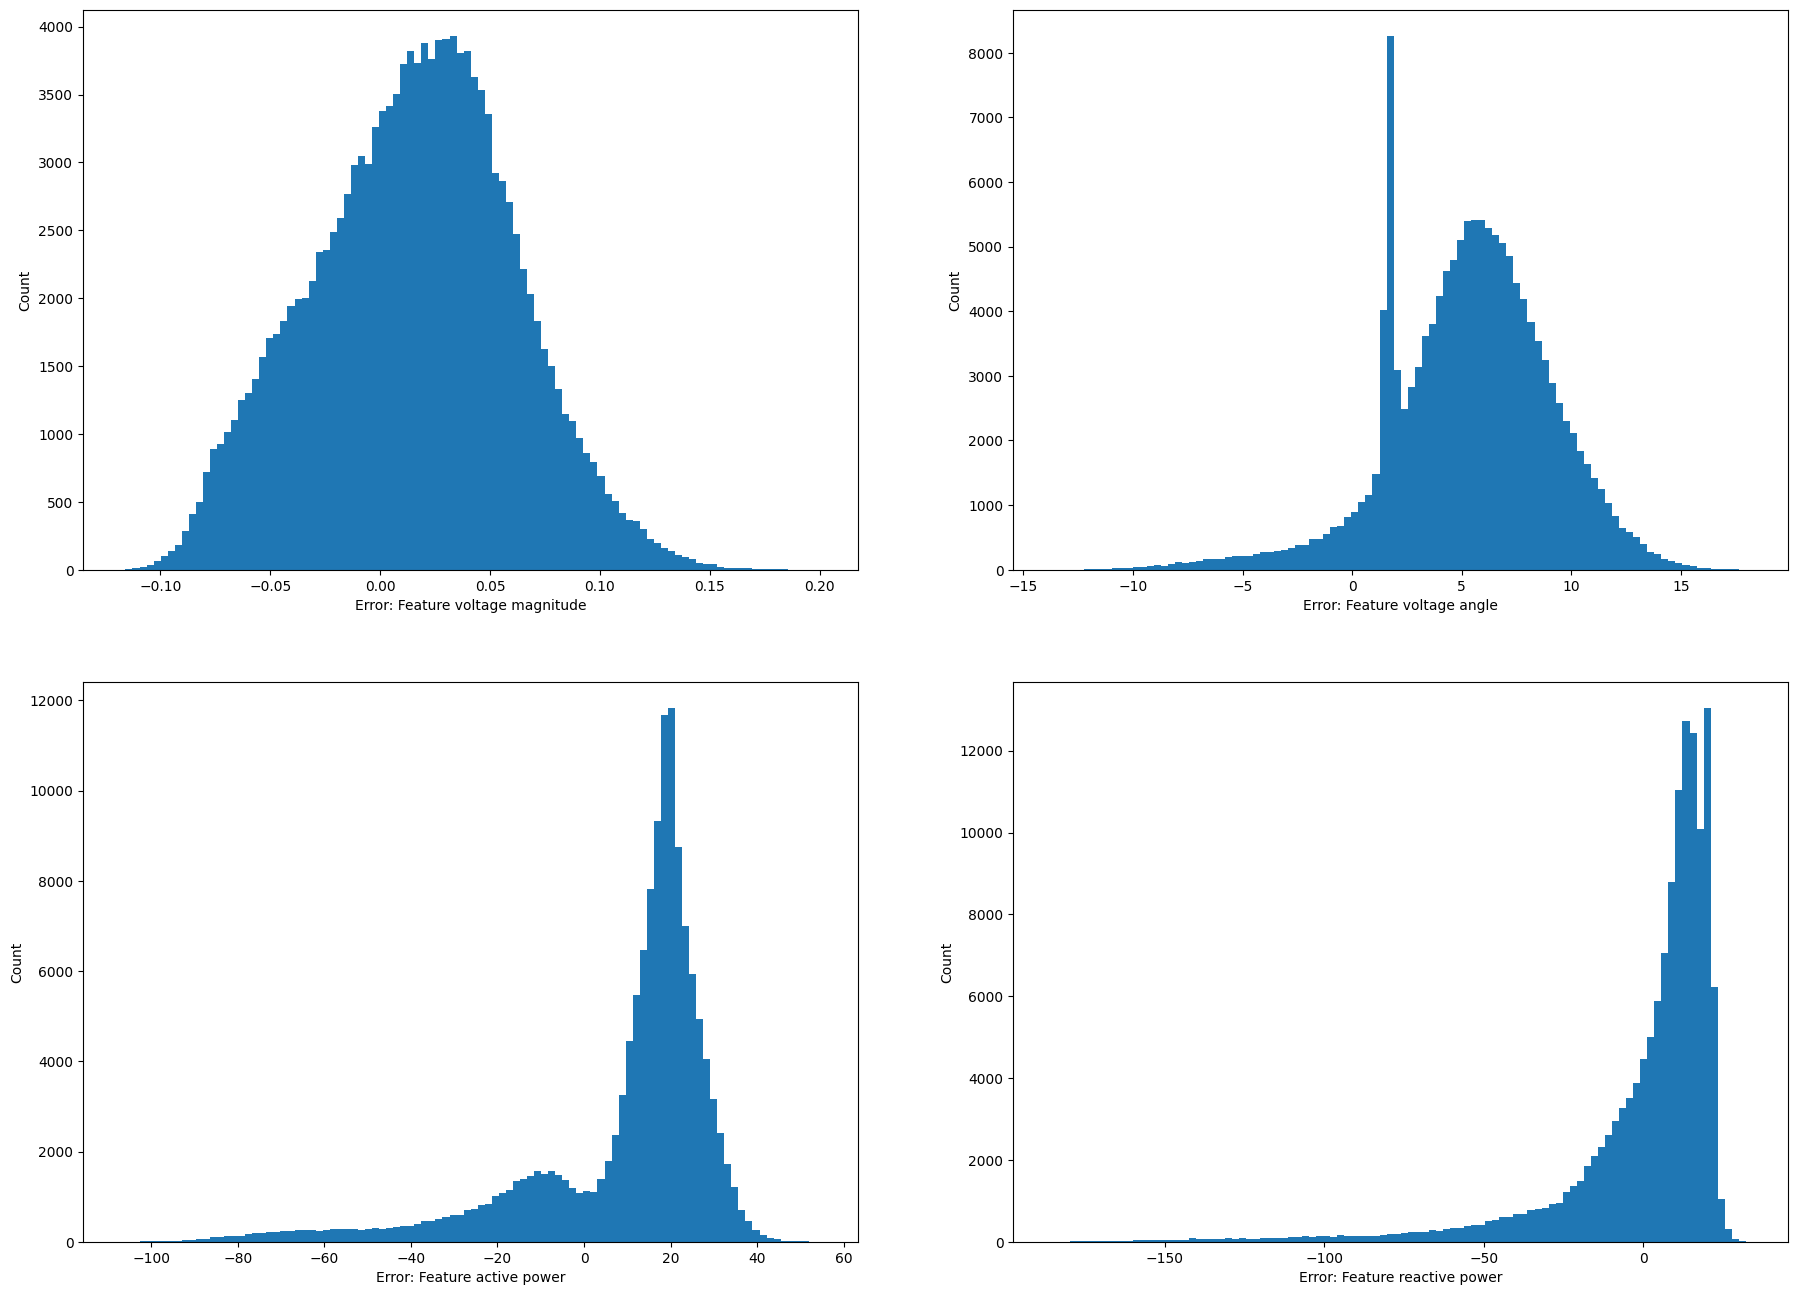

In [181]:
#plot error distribution using hist for every node
fig, axes = plt.subplots(2, 2, figsize=(22, 16))
error_per_feature = error.reshape(-1, 6)
for idx, ax in enumerate(axes.flatten()):
    ax.hist(error_per_feature[:, idx], bins=100)
    ax.set_xlabel(f'Error: Feature {feature_names_output[idx]}')
    ax.set_ylabel('Count')

plt.savefig(LOG_DIR+'/results/'+'error_distribution_'+run_id+'.png')
plt.show()


### Error for all nodes in one scenario

In [182]:
scenario_id = 200
error_scenario = error[scenario_id, :, :]
nodes = torch.arange(len(error_scenario))
target_scenario = targets[scenario_id, :, :]
pred_scenario = preds[scenario_id, :, :]

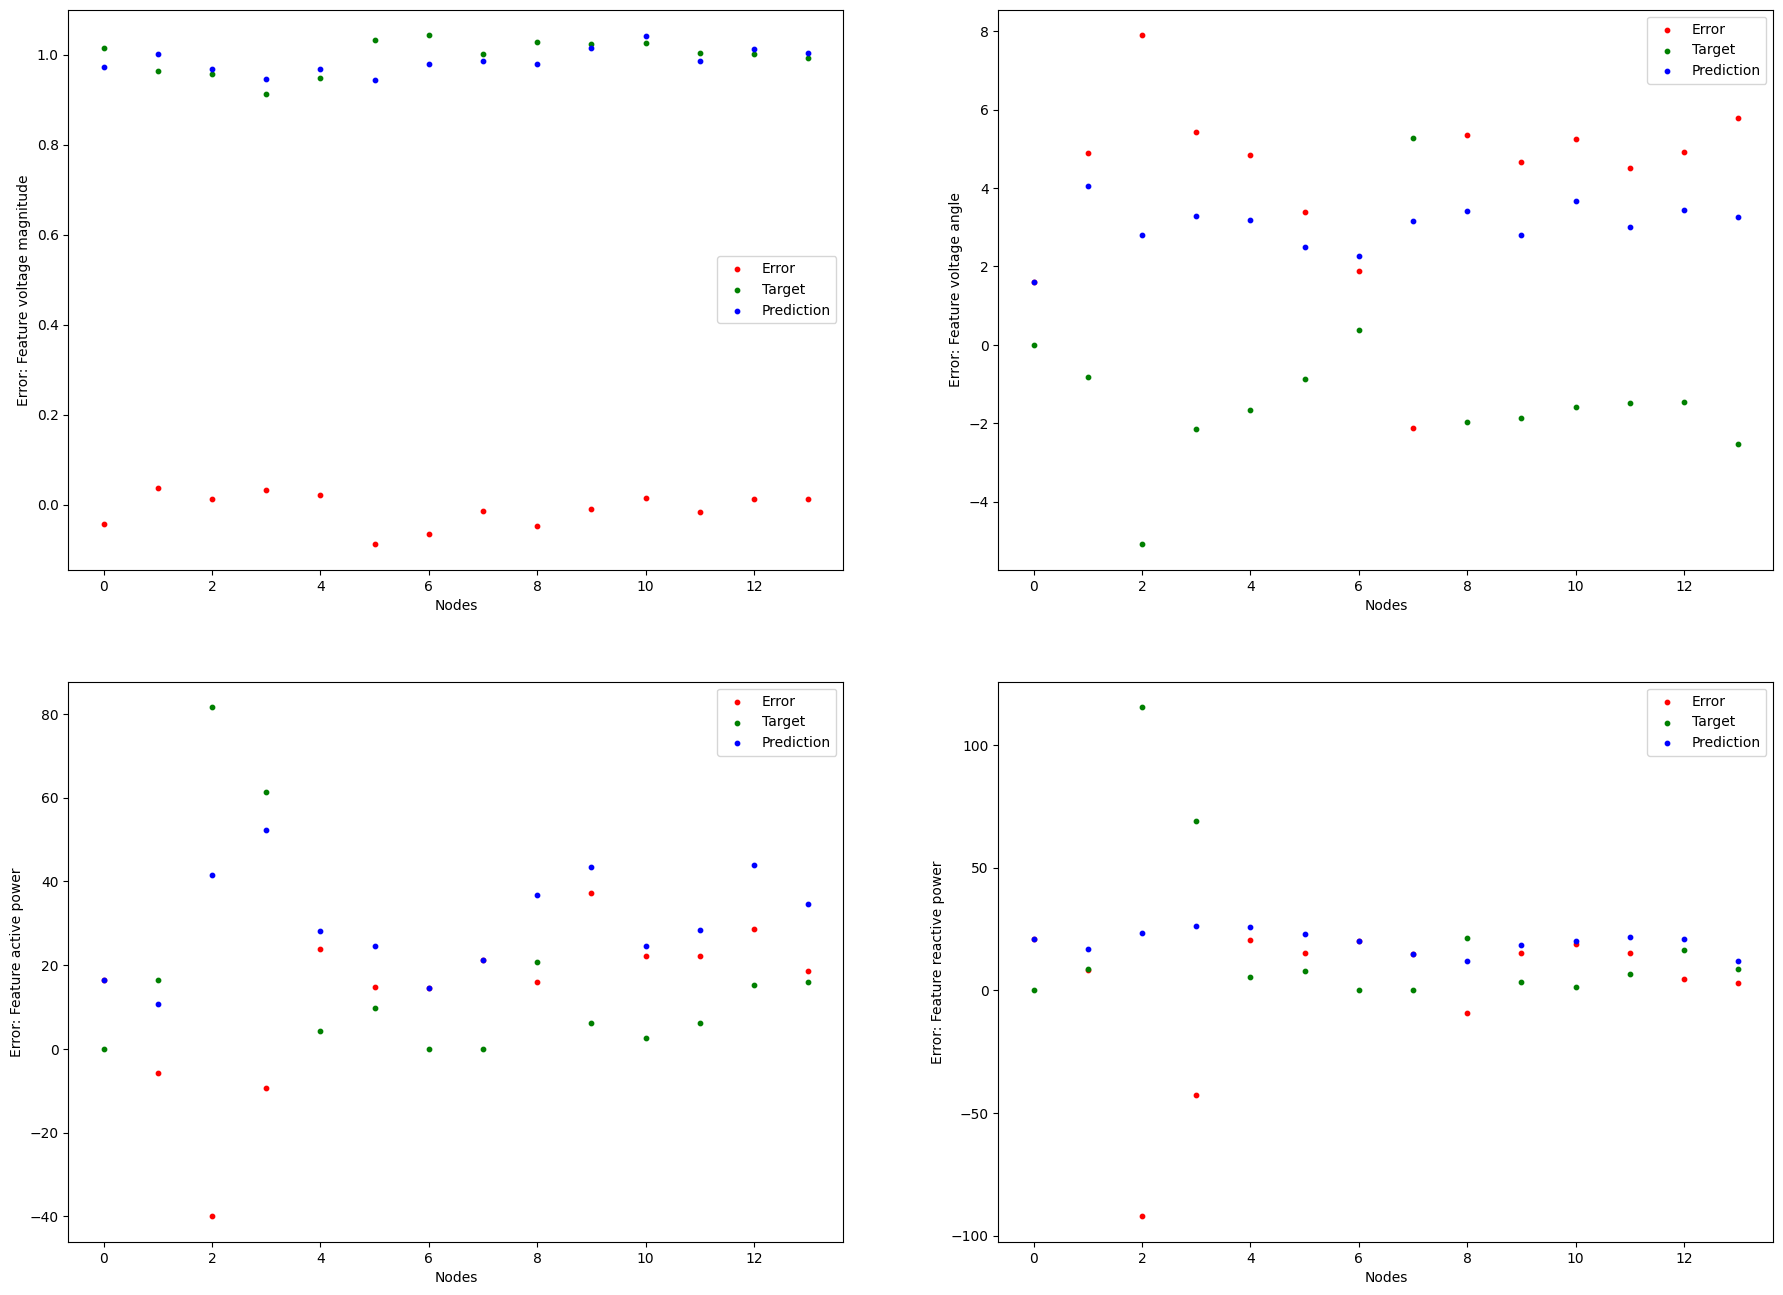

In [183]:
indices = torch.arange(len(error_scenario))

fig, axes = plt.subplots(2, 2, figsize=(22, 16))
for idx, ax in enumerate(axes.flatten()):
    ax.scatter(nodes, error_scenario[indices, idx], c='red', label='Error', s=10)
    ax.scatter(nodes, target_scenario[indices, idx], c='green', label='Target', s=10)
    ax.scatter(nodes, pred_scenario[indices, idx], c='blue', label='Prediction', s=10)
    ax.set_xlabel('Nodes')
    ax.set_ylabel(f'Error: Feature {feature_names_output[idx]}')
    ax.legend()
    
plt.savefig(LOG_DIR+'/results/'+'error_all_nodes_'+run_id+'.png')
plt.show()

**Error per Feature**

In [185]:
# preds = torch.stack(preds, dim=0).cpu()*std + mean
# targets = torch.stack(targets, dim=0).cpu()*std + mean
# error = preds - targets
print('preds', preds.shape)
print('targets', targets.shape)

# get the mean squared error for every feature[:,:,0]
error_vm = error[:,:,0].reshape(-1)
print(error_vm.shape)
loss_vm = torch.mean((error_vm))
print(loss_vm)

loss_va = torch.mean((error[:,:,1])**2)
print(loss_va)

loss_ap = torch.mean((error[:,:,2])**2)
print(loss_ap)

loss_rp = torch.mean((error[:,:,3])**2)
print(loss_rp)


preds torch.Size([10000, 14, 6])
targets torch.Size([10000, 14, 6])
torch.Size([140000])
tensor(0.0153)
tensor(42.0541)
tensor(584.6577)
tensor(691.7589)
